#Susnata's  Air Quality Clustering with Fuzzy C-Means

**Dataset:** UCI Air Quality (CO, NOx, NO2, C6H6 etc.)  

**Objective:** Use unsupervised learning (PCA + Fuzzy C-Means) to discover natural groups in pollutant measurements. I wanted
- a compact low-dimensional projection of the data (PCA) for visualization,
- robust clustering that allows partial membership (Fuzzy C-Means),
- interpretation of clusters and membership strengths, and
- simple cluster validation (silhouette score).

**Why i chose fuzzy?** Real-world pollution is continuous — a measurement can partially belong to multiple regimes (e.g., moderately polluted vs. highly polluted). FCM returns **soft membership** values instead of hard cluster labels; this is useful for ambiguous / overlapping regions.

In [1]:
!pip install -q scikit-fuzzy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 25.6 MB/s eta 0:00:00


In [2]:
#  Importing necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import silhouette_score
from google.colab import files
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [38]:
 from google.colab import files
 uploaded = files.upload()

Saving AirQualityUCI.csv to AirQualityUCI (1).csv


#Data Cleaning

In [39]:
#  Data Cleaning
df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',', engine='python') # defining parser engine

# Removing  unwanted and bad columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] # some cells are unamed used regex
df = df.replace(-200, np.nan)  # some are -200 for null vaues
df = df.drop(columns=['Date', 'Time'], errors='ignore')  # dropping redundant coumns

# Converting to numeric if any object types present
for c in df.columns:
    if df[c].dtype == object:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Selecting  pollutant columns
FEATURE_COLS = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']
df = df[FEATURE_COLS].dropna()


In [40]:
print(f" Susnata's Final cleaned data  Shape: {df.shape}") # using f string

 Susnata's Final cleaned data  Shape: (6941, 4)


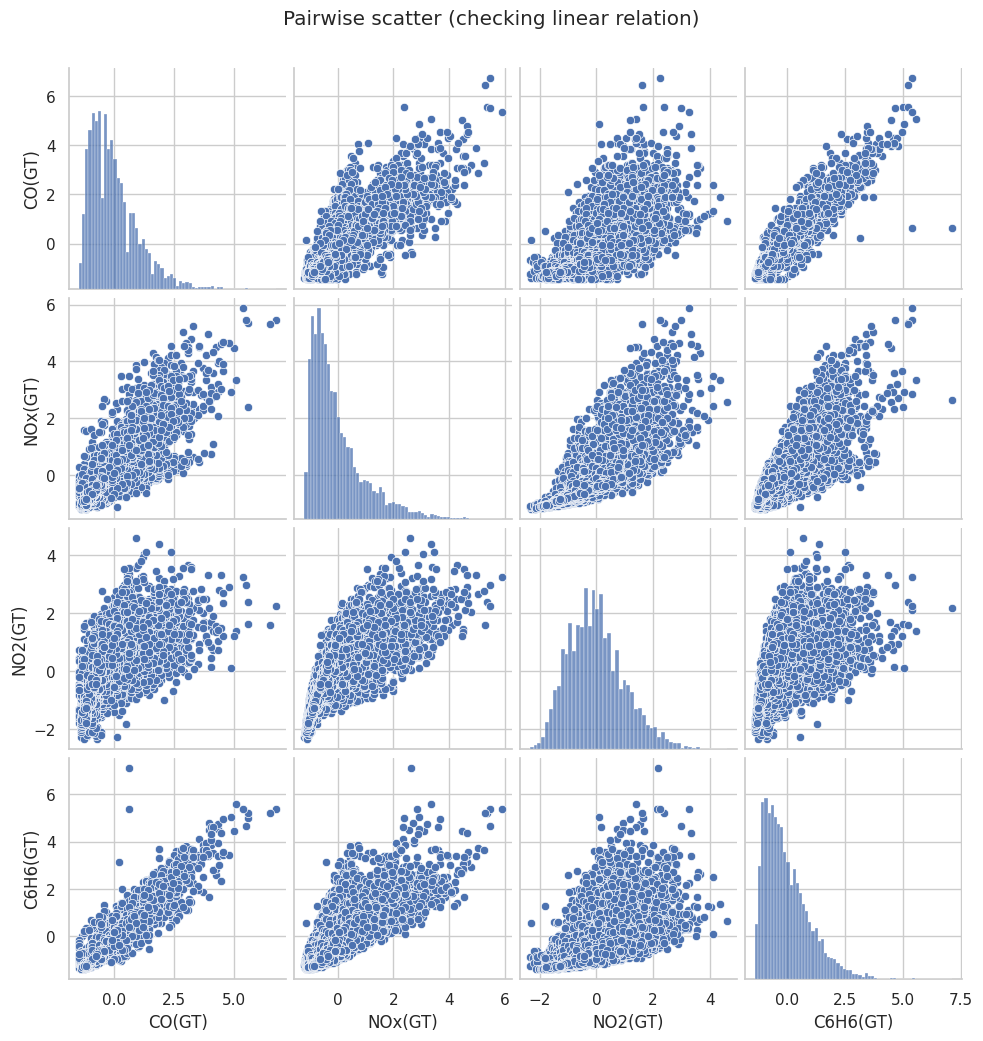

In [41]:
# Seeing  Pairwise scatter + correlation
sns.pairplot(pd.DataFrame(X_scaled, columns=FEATURE_COLS))
plt.suptitle("Pairwise scatter (checking linear relation)", y=1.04)#y is just tilte appearing relative to figure
plt.show()

In [42]:
#checking skewness
skew_vals = df.skew().sort_values(ascending=False)
print("\nSkewness Before Transformation:\n", skew_vals)


Skewness Before Transformation:
 NOx(GT)     1.643565
CO(GT)      1.339150
C6H6(GT)    1.301662
NO2(GT)     0.584348
dtype: float64


As from above some  polltants are heavily skewed and Fuzzy c being sensitive to outlier its pragmatic to do log transformation as skewnesss above 1
Also it wil not then dominate the PCA variance

In [43]:
for col in FEATURE_COLS:
    if abs(skew_vals[col]) > 1:
        df[col] = np.log1p(df[col])  # log1p handles zeros safely log 1 plus p
        print(f"Applied log1p to {col}")

Applied log1p to CO(GT)
Applied log1p to NOx(GT)
Applied log1p to C6H6(GT)


In [57]:
print("Skewness After Transformation:\n", df.skew().round(3))  # in between -0.5 and 0.5

Skewness After Transformation:
 CO(GT)      0.193
NOx(GT)    -0.297
NO2(GT)     0.584
C6H6(GT)   -0.282
dtype: float64


In [44]:
#  Scaling the data as fuzzy c sensitive to outliers
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.values) # numpy array


In [45]:
corr = pd.DataFrame(X_scaled, columns=FEATURE_COLS).corr()
print(" Correlation matrix:\n", corr)

 Correlation matrix:
             CO(GT)   NOx(GT)   NO2(GT)  C6H6(GT)
CO(GT)    1.000000  0.785366  0.705998  0.909773
NOx(GT)   0.785366  1.000000  0.818028  0.716404
NO2(GT)   0.705998  0.818028  1.000000  0.640500
C6H6(GT)  0.909773  0.716404  0.640500  1.000000


 As rule if correlation > 0.95, i can drop one column although optional as only 4 columns

# In unsupervised learning, multicollinearity will not be a problem , just redundant distances.

In [46]:
#seeing variance captured

pca = PCA()
pca.fit(X_scaled)
explained = np.round(pca.explained_variance_ratio_, 3)
cum_explained = np.cumsum(explained)
print(f"\nPCA explained variance ratios: {explained}")
print(f"Cumulative variance: {cum_explained}")


PCA explained variance ratios: [0.823 0.114 0.043 0.021]
Cumulative variance: [0.823 0.937 0.98  1.001]


From above PCA 2 pca are already capturing close to 93 percent

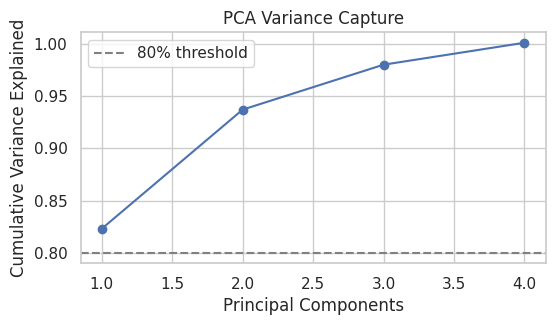

In [47]:
#Visualizing captured variance

plt.figure(figsize=(6,3))
plt.plot(np.arange(1, len(cum_explained)+1), cum_explained, marker='o')
plt.axhline(0.8, linestyle='--', color='gray', label='80% threshold')
plt.title("PCA Variance Capture")
plt.xlabel("Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.legend()
plt.show()

In [48]:
#  Reducing to 2 PCs for visualization and FCM

pca_final = PCA(n_components=2)
X_pca = pca_final.fit_transform(X_scaled)

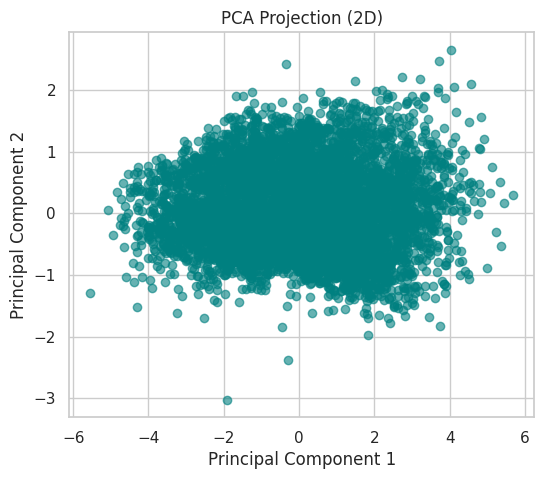

In [49]:
# Quick visualization so to confirm the linear structure or else we can explore Kernel pca
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.6, c='teal')
plt.title("PCA Projection (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

Starting fuzzy c means

In [50]:
#  Running  Fuzzy C-Means Clustering

import skfuzzy as fuzz
from sklearn.metrics import silhouette_score

C = 3        # number of clusters
M = 2.0      # fuzziness parameter as m increates it moves away from hard clustering like k means
ERROR = 1e-5  # tolerance of error to minimise loss
MAXITER = 1000  # iterations
SEED = 42  # for reproducibility


cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data=X_scaled.T, c=C, m=M, error=ERROR, maxiter=MAXITER, seed=SEED
)



cntr	 is Final cluster centers (in scaled feature space)

u	Final membership matrix   sums to 1

u0	Initial random membership matrix

d	Distance matrix between each sample and each cluster center

jm	Objective function history (how the loss decreased over iterations)

p	Number of iterations run until convergence

fpc	Fuzzy Partition Coefficient — measures how crisp my clustering is

In [51]:

hard_labels = np.argmax(u, axis=0)
sil = silhouette_score(X_scaled, hard_labels)

print(f" Fuzzy C-Means results  | FPC: {fpc:.4f} | Silhouette Score: {sil:.4f}")

 Fuzzy C-Means results  | FPC: 0.6273 | Silhouette Score: 0.3537


  FPC: 0.6273    is Moderate fuzziness (some overlap, not totally distinct clusters).

But for  environmental data (where pollution levels mix), it somewhat  realistic and good

fuzzy clusters have some overlap, which is expected since air quality is continuous hence  Silhouette Score: 0.3537

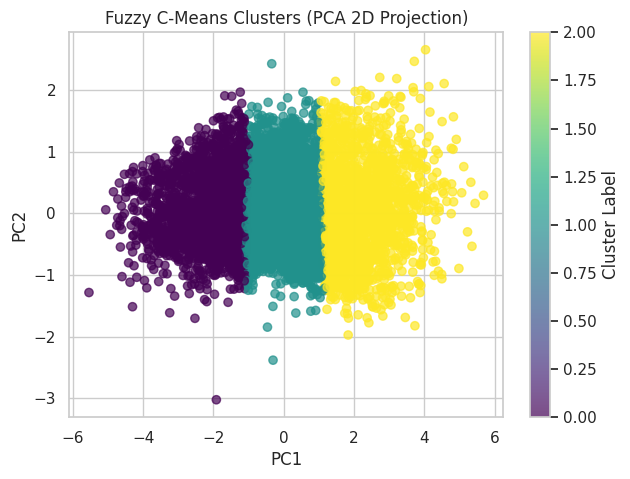

In [52]:
#  Visualizing FCM clusters in PCA space in 2d

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=hard_labels, cmap='viridis', alpha=0.7)
plt.title("Fuzzy C-Means Clusters (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster Label")
plt.show()


Cleaner boundaries and less chaotic  due to log transformation after i did expermentation,reduced skewness anmd homogenous variance

In [54]:

#hard_labels = np.argmax(u, axis=0)

df_out = df.copy()#creating a copy
for i in range(C):
    df_out[f"u_cluster_{i}"] = u[i, :]
df_out["hard_label"] = hard_labels

print("Susnata Final Cluster Memberships:")
display(df_out.head())

Susnata Final Cluster Memberships:


,CO(GT),NOx(GT),NO2(GT),C6H6(GT),u_cluster_0,u_cluster_1,u_cluster_2,hard_label
0,1.280934,5.117994,113.0,2.557227,0.047229,0.846949,0.105822,1
1,1.098612,4.644391,92.0,2.341806,0.145592,0.782579,0.071830,1
2,1.163151,4.882802,114.0,2.302585,0.039343,0.921661,0.038996,1
3,1.163151,5.153292,122.0,2.322388,0.015389,0.960165,0.024446,1
4,0.955511,4.882802,116.0,2.014903,0.118946,0.829595,0.051459,1


This final DataFrame of mine  combines soft and hard cluster information showing how each data point partially belongs to multiple pollution regimes, while also indicating its most likely cluster